# Proyecto final

 - Presentación de 15 minutos y 5 minutos de preguntas y respuestas (**30%** de la calificación del proyecto)
     - Enfoque: **recolección de datos** (técnicas, código, herramientas).
     - Resultados pueden estar incompletos
     - Cuando? 30 de Abril y 7 de Mayo
 - Reporte de máximo 5 páginas con los resultados (**70%** de la calificación del proyecto)
     - Enfoque: **Redes** (proceso de datos, creación de red, medidasde red, código)
     - Resultados: Se califica la originalidad y la calidad de las técnicas utilizadas
     - Límite Fecha de entrega: 17 de Mayo a medianoche por Teams
     - **Un PDF por equipo** con nombres de integrantes y título en portada (no cuenta como página)

# Create a graph from scratch

- Get the data
- Visualize data
- Contruct graph

# International Mathematical Olympiad

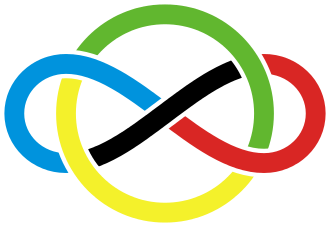

- Mathematical olympiad for pre-university students
- Since 1959
- More than 100 countries send 6 competitors
- Each competition is composed of 6 problems of 7 points each
- The winners can get gold, silver, or bronze

# 1) Get the data

### Tools

- `requests`: library to get html code
- beautifulsoup (`bs4`): library to parse through the code
- `pandas`, `numpy`, `re`

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import re

### Let's start with a single year

In [2]:
params = {'year': 1990,
          'gender': 'show',
          'nameform': 'western'}

url = 'https://www.imo-official.org/year_individual_r.aspx?'

r = requests.get(url, params=params)

Beautiful soup, helpful to parse `html`.

In [6]:
soup = BeautifulSoup(r.text, 'html.parser')

Get the first **tag** of type `script` with `soup.find('script')`.

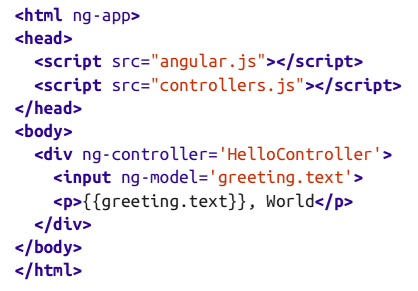

In [34]:
re.search('(id=)(\d+)', s)[2]

'2398'

In [23]:
s

'participant_r.aspx?id=2398'

In [46]:
re.search('(code=)(\w{3})', s1.a['href'])[2]

'FRA'

In [48]:
s1.a['href']

'country_individual_r.aspx?code=FRA'

We need to get the tag `table`. Within an html table, each cell has a tag `td`.

In [13]:
soup2 = soup.find('table')

In [36]:
s = soup2.find('td').a['href']
s1 = soup2.find_all('td')[1]
print(soup2.find_all('td')[2].text)

7


Inspecting the format of the table, we see a loop

- First `td` is for the person's name, id, and gender
- Second `td` is for the person's country
- Third to Ninth is for her scores in the six problems
- Tenth is for the total score
- Eleventh for its rank
- Twelveth for its medal

Write some code to extract the data from the soup.

In [51]:
columns = (['id', 'name', 'code', 'country', 'gender'] + [f'p{i}' for i in range(1, 7)]
           + ['score', 'rank', 'medal'])
data = []
scores = []
href = 0
for i, t in enumerate(soup2.find_all('td')):
    if t.a:
        s = 0
        if scores:
            data.append([pid, pname, code, country, gender] + scores)
        scores = []
        href += 1
        if href == 1:
            pid = re.search('(id=)(\d+)', t.a['href'])
            if pid:
                pid = pid[2]
            else:
                continue
            pname = t.text
            gender = np.nan
            if t.span:
                gender = t.span.text
        elif href == 2:
            country = t.text
            code = re.search('(code=)(\w{3})', t.a['href'])[2]
    else:
        s += 1
        if s > 9:
            continue
        href = 0
        scores.append(t.text)
df = pd.DataFrame(data, columns=columns)

### All years

- Since 1985

In [53]:
def get_year_table(soup2, year):
    columns = (['id', 'name', 'country', 'code', 'gender', 'year'] + [f'p{i}' for i in range(1, 7)] +
               ['score', 'rank', 'medal'])
    data = []
    scores = []
    href = 0
    for i, t in enumerate(soup2.find_all('td')):
        if t.a:
            s = 0
            if scores:
                data.append([pid, pname, country, code, gender, year] + scores)
            scores = []
            href += 1
            if href == 1:
                pid = re.search('(id=)(\d+)', t.a['href'])
                if pid:
                    pid = pid[2]
                else:
                    continue
                pname = t.text
                gender = np.nan
                if t.span:
                    gender = t.span.text
            elif href == 2:
                country = t.text
                code = re.search('(code=)(\w{3})', t.a['href'])[2]
        else:
            s += 1
            if s > 9:
                continue
            href = 0
            scores.append(t.text)
    df = pd.DataFrame(data, columns=columns)
    
    return df

In [54]:
df = pd.read_csv('../data/imo.csv')

In [ ]:
dfs = []
for year in range(1985, 2021):
    # Reset params
    params['year'] = year
    print(f"Processing {year}")
    # Get response
    r = requests.get(url, params)
    soup = BeautifulSoup(r.text)
    soup2 = soup.table
    # Create DataFrame and append
    df = get_year_table(soup2, year)
    dfs.append(df)
df = pd.concat(dfs)

In [ ]:
# Save and read dataframe
df.to_csv('../data/imo.csv', index=False)

df = pd.read_csv('../data/imo.csv')

# 2) Visualization

### Questions

- How well represented are the genders? How has it evolved over the years?
- How well planned are the exams?

### Get gender representation and plot its evolution

In [64]:
gender = (df.groupby(['year', 'code'])['gender']
          .value_counts(normalize=True)
          .rename('ratio')
          .reset_index())
gender = gender[gender['gender']=='♂']

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

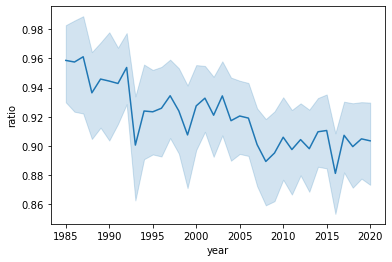

In [68]:
ax = sns.lineplot(x='year', y='ratio', data=gender)

### Measure the exam's planning

It is known that the difficulty of the 6 problems should be

$$p_1 < p_4 < p_2 < p_5 < p_3 < p_6,$$

lets see if it holds.

Melt problem columns to values into a single column

In [72]:
problem_vars = [f'p{i}' for i in range(1, 7)]
problem = df.melt(id_vars=['id', 'year'],
        value_vars=problem_vars,
        var_name='problem',
        value_name='grade')

Groupby column `problem` and get the mean of the grades.

In [ ]:
['p1', 'p4', 'p2', 'p5', 'p3', 'p3']

In [78]:
problem.groupby(['year', 'problem'])['grade'].mean().sort_values().reset_index().sort_values(['year', 'grade']).head(6)

,year,problem,grade
36,1985,p3,0.788462
77,1985,p5,1.855769
82,1985,p6,2.028846
102,1985,p4,2.423077
162,1985,p2,3.759615
180,1985,p1,4.105769


To look at the evolution of good problem planning over the years, groupby `year` and `problem` and sort values by `year` and `grade`.

In [79]:
gb_problem = (problem.groupby(['year', 'problem'])['grade']
              .mean()
              .reset_index()
              .sort_values(by=['year', 'grade']))

Compare two numpy arrays, get the number of correctly-placed elements.

In [81]:
a = np.array(['1', '2', '3'])
b = np.array(['2', '1', '3'])
c = np.array(['1', '2', '3'])
print((a == b).sum())
print((a == c).sum())

1
3


In [95]:
gb_problem['planning'].value_counts()

4    14
2     7
6     5
1     5
3     4
0     1
Name: planning, dtype: int64

In [93]:
gb_problem['planning'] = gb_problem['problem'].apply(compare_seq)

In [89]:
# Obtener para cada año un numpy:array con el orden de los problemas
gb_problem = gb_problem.groupby('year')['problem'].apply(np.array).reset_index()


In [84]:
def compare_seq(seq):
    """count number of well placed problems"""
    correct = np.array(['p6', 'p3', 'p5', 'p2', 'p4', 'p1'])
    return (seq == correct).sum()

Plot correctly planned problems over the years

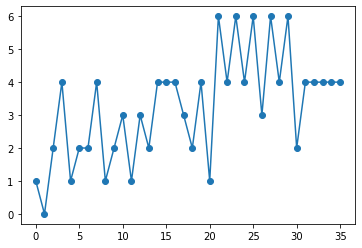

In [97]:
_ = (gb_problem['planning']
     .plot(marker='o'))

# 3) Network

Let's make a network connecting countries with similar scores.

 1. Calculate pairwise Pearson correlation of countries
 2. Join those with an edge if their correlation is high

Get the mean of each problem by country. Set the country as the index.

In [98]:
country = df.groupby('code')[['p1', 'p2', 'p3', 'p4', 'p6']].mean().reset_index()

In [99]:
country = country.set_index('code')

Get the country pairwise correlation matrix.

In [103]:
matrix = country.T.corr(method='pearson')

In [104]:
# Better to have the numpy array
M = matrix.values

Create edgelist for countries with correlation greater than 0.99

In [107]:
c = 0.99
edges = []
for i in range(len(M) - 1):
    for j in range(i + 1, len(M)):
        if M[i][j] > c:
            code1 = matrix.index[i]
            code2 = matrix.index[j]
            edges.append([code1, code2])

Let's create the network using `graph_tool`.

In [108]:
import graph_tool.all as gt

In [109]:
g = gt.Graph(directed=False)
ids = g.add_edge_list(edges, hashed=True)

Plot the network

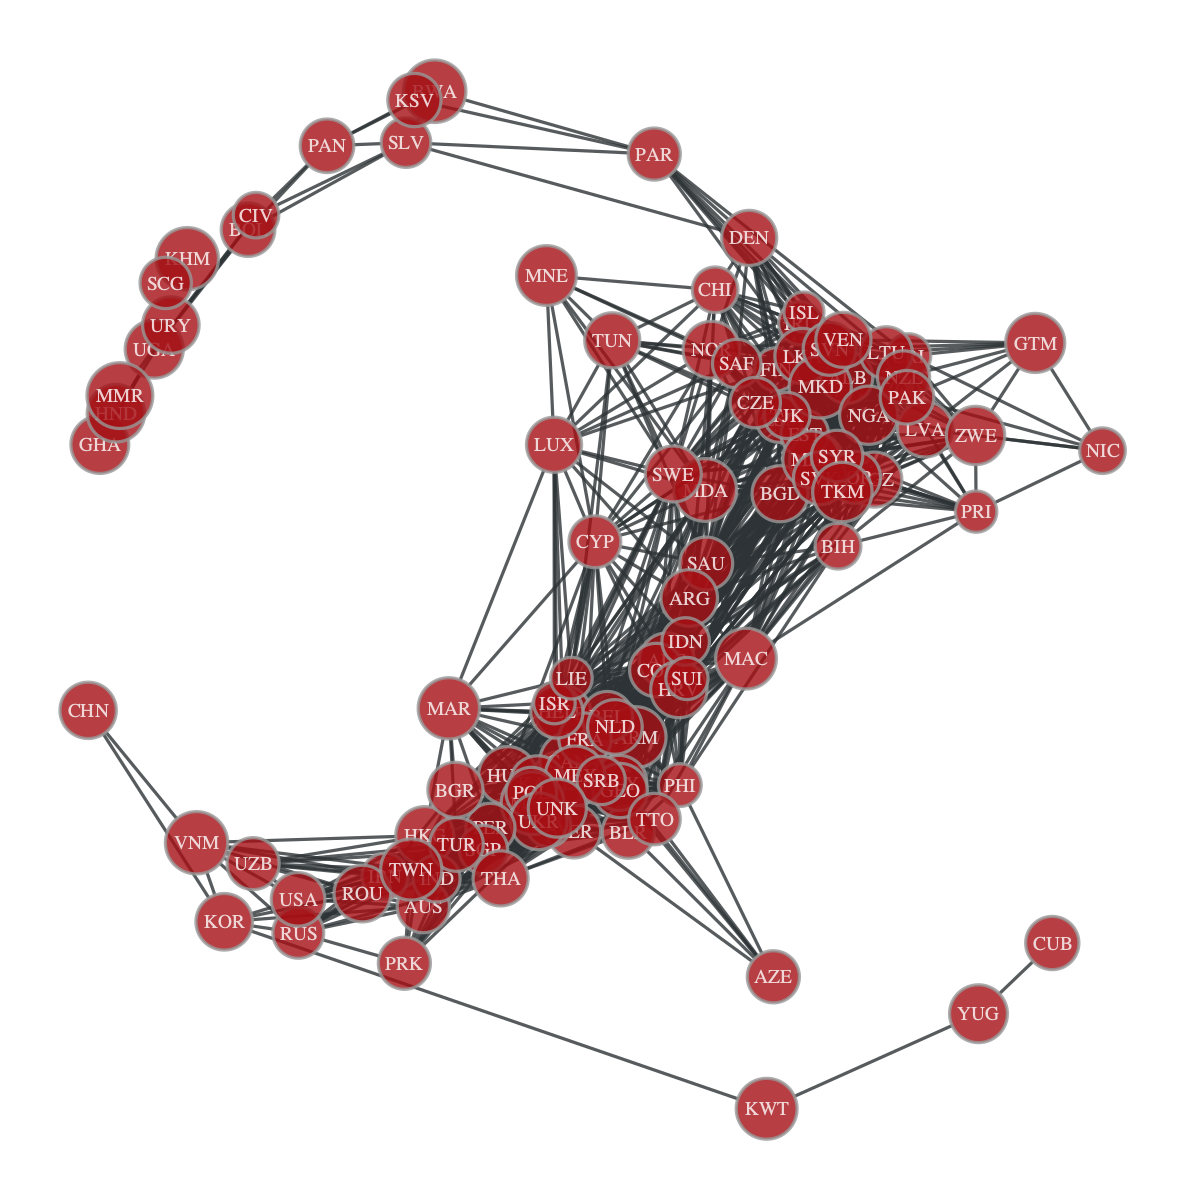

In [110]:
# Set the positions
pos = gt.arf_layout(g)
_ = gt.graph_draw(g,
                  pos=pos,
                  vertex_text=ids)

Get communities within the network

In [111]:
status = gt.minimize_blockmodel_dl(g)
# Get the communities
b = status.get_blocks()

Plot of the communities with the same positions

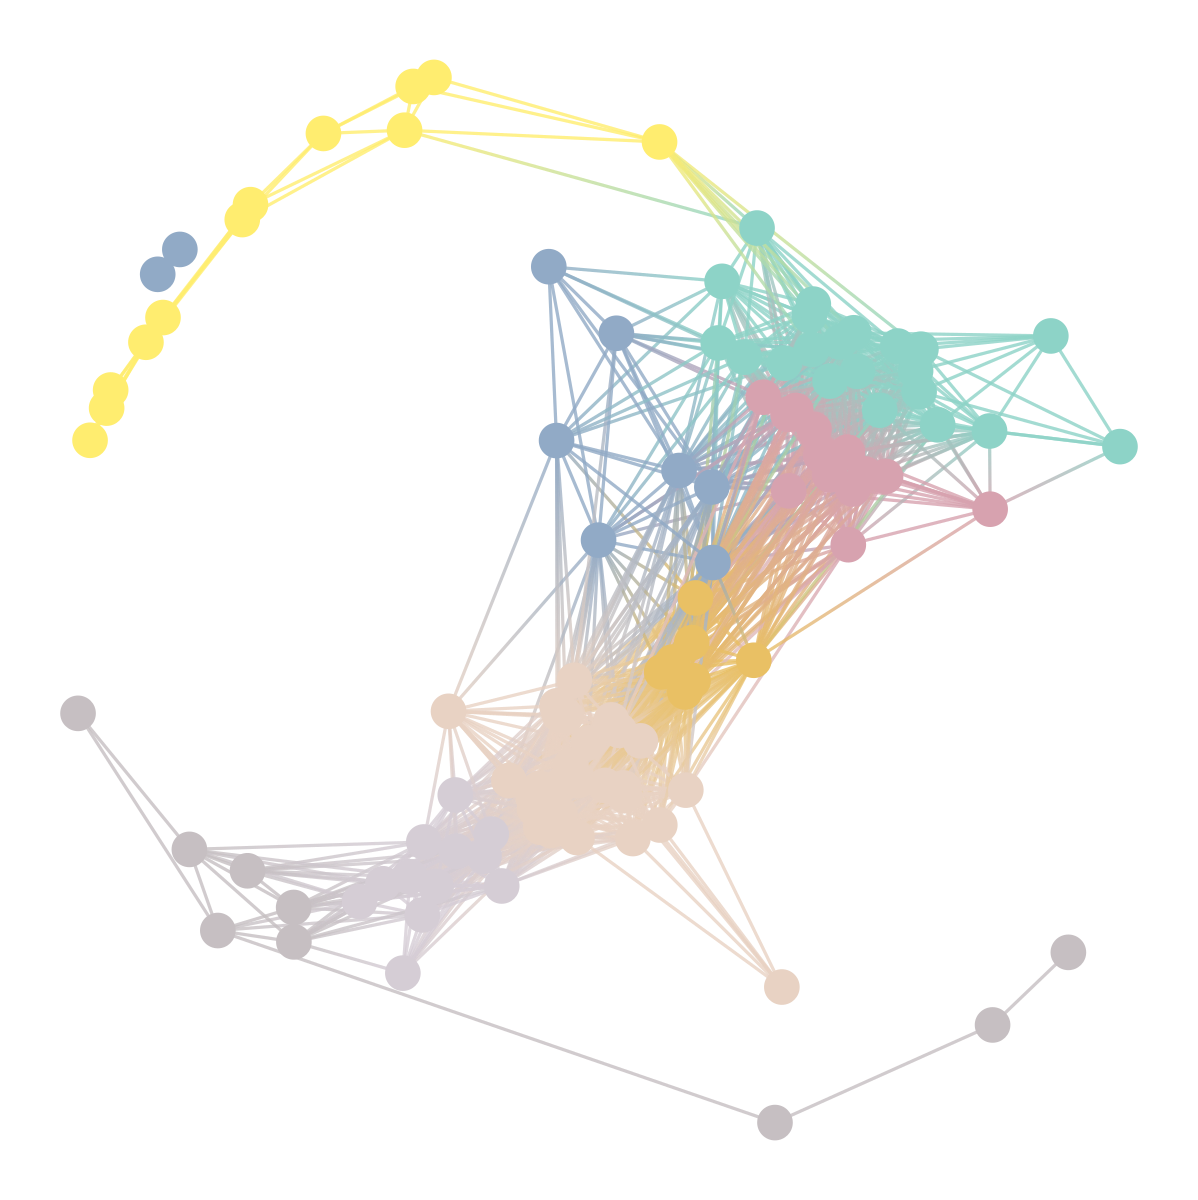

In [112]:
_ = status.draw(pos=pos)

Create dataframe with two columns: block and country code.

In [113]:
blocks = []
for v in g.iter_vertices():
    blocks.append([ids[v], b[v]])
blocks = pd.DataFrame(blocks, columns=['code', 'block'])

In [ ]:
blocks.head()

Add full name for each country code

In [116]:
cc = df.groupby('code')['country'].first().reset_index()
# Merge with blocks
blocks = pd.merge(blocks, cc, how='left')

Explore

In [121]:
blocks[blocks['block']==4]

,code,block,country
35,ARM,4,Armenia
36,AUT,4,Austria
37,BEL,4,Belgium
38,BLR,4,Belarus
39,BRA,4,Brazil
40,CAN,4,Canada
43,EGY,4,Egypt
44,FRA,4,France
45,GEO,4,Georgia
46,GER,4,Germany
